<a href="https://colab.research.google.com/github/annapahl24/exercise10/blob/main/Copy_of_CompModNervSys_exercise10_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BIOL 74.03 (SP23): Computational Modeling of the Nervous System
# Exercise 10: Nonlinear synaptic mechanisms in dendrites - part 2/2

### Exercise goals

Part 1 ([CompModNervSys_exercise10_part1](https://github.com/CompModNervSystem/CompModNervSys-NonLinearDendrites/blob/main/CompModNervSys_exercise10_part1.ipynb)):

1) Simulate a morphologically realistic model of a neocortical layer 5 pyramidal neuron

2) Understand how dendritic spines locally amplify postsynaptic potentials

3) Understand how NMDA spikes can amplify distal synaptic inputs as a function of the number and location of activated synapses

### **Part 2** ([CompModNervSys_exercise10_part2](https://github.com/CompModNervSystem/CompModNervSys-NonLinearDendrites/blob/main/CompModNervSys_exercise10_part2.ipynb)):

1) Understand how somatic action potentials affect dendritic membrane potential in the form of backpropagating action potentials (bAPs)

2) Demonstrate how bAPs and synaptic inputs can generate bAP-activated calcium spikes to function as a coincidence detector


Work through the code below, running each cell, adding code where required, and making sure you understand the output. When you see questions with <font color='red'>***Q:*** </font> preceding them, write your responses in text cells.


Install neuron into this runtime environment (may be unneccessary if you just completed part 1 in the same runtime).

In [1]:
%pip install neuron # only need to run this cell once to install
                    # neuron in the local jupyter environment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 32.0 MB/s eta 0:00:00


Run the code block below just once to get all the files from the repository into our colab session and compile the MOD mechanism files we'll be using (same as above, only necessary in new runtime)

In [2]:
repo_name = 'CompModNervSys-NonLinearDendrites'
if 'google.colab' in str(get_ipython()):
    import os
    if not os.path.exists(repo_name):
        !git clone https://github.com/CompModNervSystem/{repo_name}.git # downloads repository into our Google colab session's file system

    os.chdir(repo_name)

# Compile mechanisms
!nrnivmodl mechanisms

Cloning into 'CompModNervSys-NonLinearDendrites'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 40 (delta 10), reused 38 (delta 8), pack-reused 0
Receiving objects: 100% (40/40), 185.72 KiB | 2.11 MiB/s, done.
Resolving deltas: 100% (10/10), done.
/content/CompModNervSys-NonLinearDendrites
Mod files: "mechanisms/mechanisms/CaDynamics_E2.mod" "mechanisms/mechanisms/Ca_HVA.mod" "mechanisms/mechanisms/Ca_LVAst.mod" "mechanisms/mechanisms/Ih.mod" "mechanisms/mechanisms/Im.mod" "mechanisms/mechanisms/K_Pst.mod" "mechanisms/mechanisms/K_Tst.mod" "mechanisms/mechanisms/Nap_Et2.mod" "mechanisms/mechanisms/NaTa_t.mod" "mechanisms/mechanisms/ProbAMPANMDA.mod" "mechanisms/mechanisms/ProbGABAA.mod" "mechanisms/mechanisms/SK_E2.mod" "mechanisms/mechanisms/SKv3_1.mod"

Creating 'x86_64' directory for .o files.

 -> Compiling mod_func.cpp
 -> NMODL ../mechanisms/CaDynamics_E2.mod
 -> NMODL ../mecha

## Introduction

At this point, you should have read the introduction and completed part 1 of the exercise. In part 2, we'll combine synaptic input with action potentials generated by synaptic current injection (representing more proximal inputs driving action potential initiation or a stimulation by an experimenter's microelectrode).

Start by importing the packages we'll be using. If you restart your session at any point, you'll want to start from here

In [3]:
from neuron import h # all NEURON hoc functions are accessed through h
from neuron import gui # if you're running this notebook in a local environment (instead of on google colab), launches the GUI
h.load_file('stdrun.hoc') # loads neuron standard hoc library, not always necessary
import numpy as np
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
import matplotlib.pyplot as plt
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go

if 'google.colab' in str(get_ipython()): # For making interactive plots work on google colab
    from google.colab import output
    output.enable_custom_widget_manager()
else:
    plotly.offline.init_notebook_mode() # for printing notebooks offline

# bAP-activated calcium spiking and coincidence detection

As you know, when a neuron fires an action potential (AP), typically initiating in the axon initial segment, the AP propogates forward throughout the axon towards its presynaptic terminals. This forward propagation is referred to as the *orthodromic* direction. But the action potential also is capable of propagating *antidromically* into the soma and dendritic arbor, known as backpropagation. It turns out this backpropagating action potential (bAP), similar to axonal APs, relies on voltage-gated ion channels to overcome the normally leaky properties of neuronal membranes that would cause the somatic AP to attenuate.

Let's explore how the bAP arises and its consequences for synaptic integartion.

We start as we did in exercise 1, instantiating an L5 PC neuron model using the `createL5PC` helper function. This time, we'll add synapses and spines to `L5PC.apic[36]`.

Populate this branch with a spine every $2\; \mu m$. This code block includes the code to generate all the AMPA/NMDA synapses, gives them a weight of 0.5, and turns them off to start.

In [4]:
from helper_functions import createL5PC

morphology_file = "morphologies/cell1.asc" # morphology file
spine_seclist_name = 'apical' # either 'apical' or 'basal'
spine_sec_ind = 36 # specify index of branch within section list
spine_interv = 2 # spacing between spines in µm

L5PC = createL5PC(morphology_file,spine_seclist_name,spine_sec_ind,spine_interv)

# Create recording vectors for time and somatic voltage, since we know we'll need these later
t_vec = h.Vector().record(h._ref_t)
v_soma = h.Vector().record(L5PC.soma[0](0.5)._ref_v)

# Create a synapse for each spine
synapses = [] # Store synapses
netstims = [] # Store NetStims
netcons = [] # Store NetCons
# recording vectors for voltage and current at each synapse (spine head)
v_syns = [] # voltage recordings
i_syns = [] # synaptic current recordings
i_AMPAs = [] # AMPAr specific currents
i_NMDAs = [] # AMPAr specific currents
ica_syns = [] # calcium currents in synaptic segments
synapse_names = [] # string names for each synapse
for i in range(int(L5PC.nSecSpines)):
    synapses.append(h.ProbAMPANMDA(L5PC.spine_head[i](0.5)))
    netstims.append(h.NetStim())
    netcons.append(h.NetCon(netstims[i],synapses[i]))
    v_syns.append(h.Vector().record(L5PC.spine_head[i](0.5)._ref_v))
    i_syns.append(h.Vector().record(synapses[i]._ref_i))
    i_AMPAs.append(h.Vector().record(synapses[i]._ref_i_AMPA))
    i_NMDAs.append(h.Vector().record(synapses[i]._ref_i_NMDA))
    ica_syns.append(h.Vector().record(L5PC.spine_head[i](0.5)._ref_ica))
    synapse_names.append('spine[{}]'.format(i))

# Set parameters of all neuron objects within a list
def setParams(obj_list, indices,settings):
    # obj_list - list of synapses, netstims, or netcons
    # indices - array of indices (integers) of NetStims within the lists to modify
    # settings - dictionary of key, value pairs, should match fields of object in list
    for i in indices:
        obji = obj_list[i]
        for key, val in settings.items():
            h('{}.{} = {}'.format(obji.hname(),key,val))

# Set all the weights to 0.5 (peak conductance of 0.5 nS) and delays to 1 ms
setParams(netcons,range(len(synapses)),{'weight':0.5,'delay':1})
# turn off netstims for now
setParams(netstims,range(len(synapses)),{'number':0})

Set nseg to 245  in L5PCtemplate[0].apic[36]
Added 122 spines to apic[36] every 2 um
  neck_diam = 0.1 um, head_diam = 0.5 um


Now, we'll want to add a current injection to the soma to initiate somatic APs. In the code block below, add an `IClamp` to the soma and set its duration (`dur`) to $5 \; ms$ and `delay` to $100 \; ms$. We'll set the amplitude later.

The code block below also creates recordings from a few additional locations along the apical dendrite to characterize how the AP amplitude changes as we move away from the soma (middle segment of `L5PC.apic[0]`,`L5PC.apic[36]`,`L5PC.apic[60]`,`L5PC.apic[67]`).

In [5]:
# Current clamp in soma to drive somatic AP
stim = h.IClamp(0.5,sec = L5PC.soma[0])
stim.dur = 5
stim.delay = 100 # allow time for model to equilibriate
stim_current = h.Vector().record(stim._ref_i) # record injected current

# Record from a few locations in the apical dendrite
apic_rec_inds = [0,36,60,67]
v_apics = []
apic_rec_segs = []
for ind in apic_rec_inds:
    apic_rec_segs.append(L5PC.apic[ind](0.5))
    v_apics.append(h.Vector().record(L5PC.apic[ind](0.5)._ref_v)) # middle of sections

from helper_functions import get_seclist_dists # function for calculating distance from soma of middle segment in a section list

if len(synapses) > 0:
    syn_dists = get_seclist_dists(L5PC,'spine_heads') # distance from soma of all spine heads

apic_dists = get_seclist_dists(L5PC,'apical') # distance from soma of all apical sections (middle)
apic_rec_dists = apic_dists[apic_rec_inds] # distance from soma of recorded apical compartments

### Visualize morphology

Now let's visualize our cell's morphology and the location of the synapses we added.

In [6]:
ps = h.PlotShape(False) # generate a NEURON PlotShape object
# Synapse locations
fig = ps.plot(plotly) # Plot using plotly's renderer
scene=dict(camera=dict(up=dict(x=0,y=1,z=0),eye=dict(x=2,y=2,z=2.5)), # define view properties
           xaxis=dict(nticks=3,showticklabels=True),
           yaxis=dict(nticks=3,showticklabels=True),
           zaxis=dict(nticks=3,showticklabels=True),
           aspectmode='data', #this string can be 'data', 'cube', 'auto', 'manual'
           )
fig.update_layout(scene=scene,autosize=False,width=400,height=600)
for syn in synapses: # Mark each synapse
    fig.mark(syn.get_segment())
fig.update_layout(title='Synapse locations')
plotly.io.show(fig)


### Run the simulation

Now let's see how activating either the somatic current injection, the dendritic inputs, or both alters the output of the neuron.

To turn on our synapses, we'll use `turnOnSynapses` again, but this time importing it from the `helper_functions.py` python file. We'll also import `plot_result` which will just help us make some pretty plots.

Start by turning on 5 synapses alone. Use a simulation duration of $200 \; ms$ ()`h.tstop`), initial voltage (`h.v_init`) of $-80 mV$, and a temperature of $37 ^{\circ} C$.

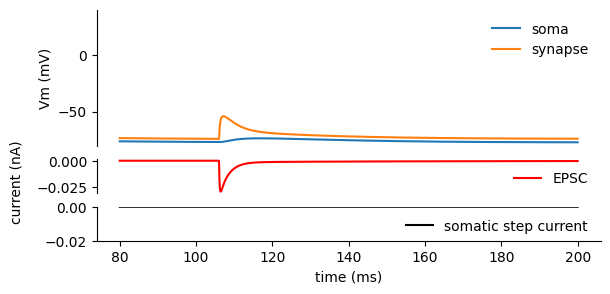

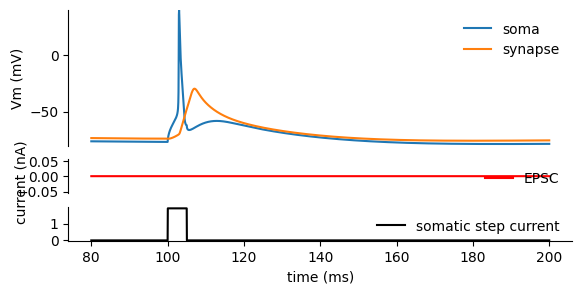

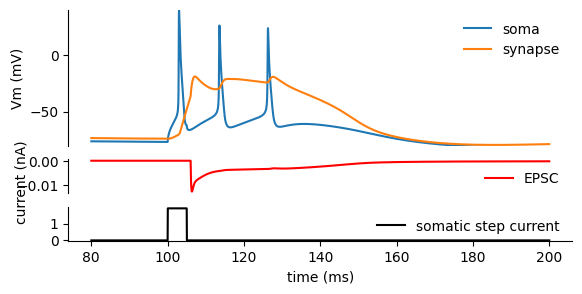

In [7]:
from helper_functions import turnOnSynapses, plot_result

curr_amp = 1.9 # nA - somatic step current amplitude
n_synapses_on = 20 # number of synapses to turn on
distribute_mode = 'even' # how to distribute them within the section
start_time = stim.delay+stim.dur # when to deliver EPSP

h.celsius = 37 # deg C
h.tstop = 200 # ms
h.v_init = -80 # mV

# EPSP only
stim.amp = 0 # turn off somatic current injection
# Turn on desired number of synapses
syn_indices = turnOnSynapses(n_synapses_on,'sequential',netstims,{'number':1,'start':start_time})
h.run()
fig = plot_result(t_vec, v_soma, v_syns[syn_indices[0]], stim_current, i_syns[syn_indices[0]],
                  show_from = stim.delay - 20);

# Somatic step current only
stim.amp = curr_amp # (nA) turn on current injection
setParams(netstims,range(len(synapses)),{'number':0}) # turn off all synapses
h.run()
fig2 = plot_result(t_vec, v_soma, v_syns[syn_indices[0]], stim_current, i_syns[syn_indices[0]],
                   show_from = stim.delay - 20);

# # EPSP + step current
stim.amp = curr_amp # (nA) turn on current injection
syn_indices = turnOnSynapses(n_synapses_on,'sequential',netstims,{'number':1,'start':start_time}) # turn on synapses
h.run()
fig3 = plot_result(t_vec, v_soma, v_syns[syn_indices[0]], stim_current, i_syns[syn_indices[0]],
                   show_from = stim.delay - 20);

<font color='red'>**Q1**:
Describe how the somatic and (local) dendritic voltage respond to the EPSP alone, somatic step current alone, and the combination of the two. Make sure to explain possible reasons for the differences (e.g., referencing cable properties, ion channel dynamics, synaptic currents, etc.).
</font>

EPSP alone causes a really small voltage spike in the soma and a slightly larger one at the synapse. The minimal voltage spike in the soma could be attributed to the passive propagation of the EPSP from the dendritic compartment to the soma. Due to cable properties and the passive spread of current, the EPSP attenuates as it travels along the dendrite towards the soma.

Somatic step current alone causes a bigger spike at the synapse and an action potential at the soma. The injection of current directly into the soma results in a more significant depolarization due to the direct stimulation of the voltage-gated ion channels responsible for generating action potentials and the dendritic compartment also responds to this current injection although at a later time than the soma/action potential (due to the propogation time within the neuron).

Both together causes an array of 3 action potentials at the soma and a prolonged voltage increase at the synapse. When both the EPSP and somatic step current are applied simultaneously, the soma experiences a more significant depolarization, leading to the generation of action potentials. The prolonged voltage increase observed at the synapse is a result of the combined effect of EPSP and the depolarizing effect of the action potentials in the soma, which influence the local dendritic voltage in tandem so it never decays fully.

Hopefully you noticed combining the synaptic inputs with the $5 \; ms$ somatic current injection generates multiple action potentials in quick succession (a *burst*).

Below, explore how the timing of the EPSP relative to the somatic step current affects the induction of burst firing.

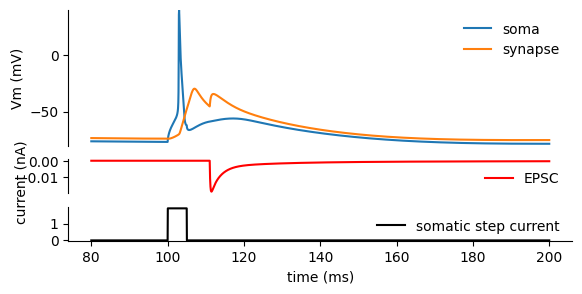

In [8]:
# set epsp_offset to shift presynaptic input timing relative to step current
epsp_offset = 5 # offset from end of current step

curr_amp = 1.9 # nA - somatic step current amplitude
n_synapses_on = 20 # number of synapses to turn on
distribute_mode = 'even' # how to distribute them within the section
start_time = stim.delay+stim.dur + epsp_offset # when to deliver EPSP

# EPSP + step current
# Turn on synapses and set timing
syn_indices = turnOnSynapses(n_synapses_on,'sequential',netstims,{'number':1,'start':start_time}) # turn on synapses
stim.amp = curr_amp

h.run()
fig = plot_result(t_vec, v_soma, v_syns[syn_indices[0]], stim_current, i_syns[syn_indices[0]],
                  show_from = min(start_time,stim.delay) - 20);

<span style="color:red">**Q2**: In this case, what is the time window in which a dendritic excitatory input and somatic AP (evoked by current injection) combine to produce burst firing?
</span>

We observe more than 1 AP for an offset of 4 ms or less only. The window is super small but this makes sense considering the extreme synchronicity required- that we have discussed.

Let's investigate what ion channels are responsible for this behavior.

Below, use the `toggleChannelSeclist` function we introduced in part 1 to address this question. You'll want to turn off conductances in the relevant region of the neuron to demonstrate their necessity for the burst firing. I'll repeat the description of this function here so you don't have to switch windows:

The `toggleChannelSeclist` function below allows you to turn off (or back on) any of the channels present in the model in one of the subregions, which are organized into `SectionList`s. The possible section lists are available within the cell object (`L5PC` in this case) and include `L5PC.apical`, `L5PC.basal`, `L5PC.somatic`, or `L5PC.axonal`. The spines also have channels placed in the `spine_head` section mimicking their parent branch, which are included in the `spine_heads` `SectionList`.

To specify the channels to switch off/on, I've simplified things a bit to allow you to set groups of channels by setting `channel_type` to one of the following strings:

- `'Cav'` - voltage-gated calcium channels, sections may include a low-voltage activated and high-voltage activated channel
- `'Kv'` - voltage-gated potassium channels, sections may include a Kv3 channel, and a transient and persistent potassium conductance (only present in the soma)
- `'Nav'` - voltage-gated sodium cahnnels, sections may include a transient (inactivating) and persistent (non-inactivating) Nav conductance
- `'Kca'` - calcium-activated potassium channel
- `'Ih'` - hyperpolarization activated current

Turned off Ih currents in SectionList
Reverted conductances back to default values


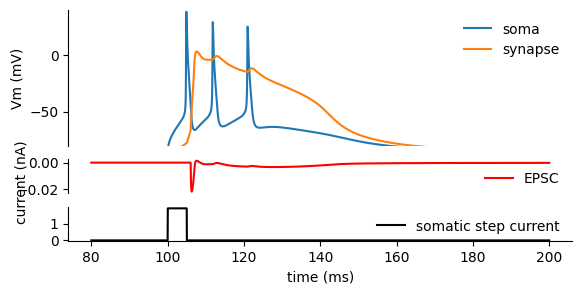

In [9]:
from helper_functions import toggleChannelSeclist

channel_type = 'Ih'
seclist = L5PC.apical

toggleChannelSeclist(channel_type,L5PC,seclist,turn_off=True)

curr_amp = 1.9 # nA - somatic step current amplitude
n_synapses_on = 100 # number of synapses to turn on
distribute_mode = 'even' # how to distribute them within the section
start_time = stim.delay+stim.dur  # when to deliver EPSP

# EPSP + step current
# Turn on synapses and set timing
syn_indices = turnOnSynapses(n_synapses_on,'sequential',netstims,{'number':1,'start':start_time}) # turn on synapses
stim.amp = curr_amp

h.run()

fig = plot_result(t_vec, v_soma, v_syns[syn_indices[0]], stim_current, i_syns[syn_indices[0]],
                  show_from = min(start_time,stim.delay) - 20);

toggleChannelSeclist(channel_type,L5PC,seclist,turn_off=False)   # reverts conductances to defaults


<font color='red'>**Q3**: Which dendritic ion channels are required for this bAP-dependent burst firing to occur? Can you turn up the number of synapses and still induce bursting with these channels on or off?  
</font>

With 20 synapses on, either potassium channel needs to be on to induce burst firing. Bursts can be induced by increasing the number of channels on for the other channel types (Calcium, sodium, hyperpolarization).

Finally, let's use our dendritic recording locations to measure the bAPs attenuation as it gets further from the soma.
It may help to first visualize the morphology with our dendritic recording locations.

In [10]:
# Recording locations
ps = h.PlotShape(False) # generate a NEURON PlotShape object
# Synapse locations
fig2 = ps.plot(plotly) # Plot using plotly's renderer
scene=dict(camera=dict(up=dict(x=0,y=1,z=0),eye=dict(x=2,y=2,z=2.5)), # define view properties
           xaxis=dict(nticks=3,showticklabels=True),
           yaxis=dict(nticks=3,showticklabels=True),
           zaxis=dict(nticks=3,showticklabels=True),
           aspectmode='data', #this string can be 'data', 'cube', 'auto', 'manual'
           )
fig2.update_layout(scene=scene,autosize=False,width=400,height=600)
for seg in apic_rec_segs: # Mark each synapse
    fig2.mark(seg)
fig2.update_layout(title='Apical dendrite recording locations')
plotly.io.show(fig2)

Run a simulation with the step current alone. I've imported another helper function called `get_peaks` that extracts the peak value subracted by the baseline from each vector within a list. The code block below uses it to get the peak EPSP at each recording location. Use this output to plot the peak EPSP vs. distance, which we stored in the `syn_dists` variable earlier.

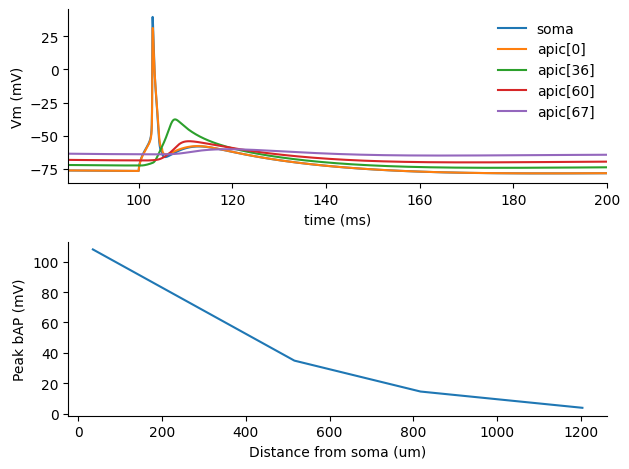

In [11]:
from helper_functions import get_peaks

curr_amp = 1.9 # nA - somatic step current amplitude
n_synapses_on = 20 # number of synapses to turn on
distribute_mode = 'even' # how to distribute them within the section
start_time = stim.delay+stim.dur # when to deliver EPSP

h.celsius = 37 # deg C
h.tstop = 200 # ms
h.v_init = -80 # mV

# Somatic step current only
stim.amp = curr_amp # (nA) turn on current injection
setParams(netstims,range(len(synapses)),{'number':0}) # turn off all synapses
h.run()
# fig2 = plot_result(t_vec, v_soma, v_syns[syn_indices[0]], stim_current, i_syns[syn_indices[0]],
#                    show_from = stim.delay - 20);


apic_rec_peaks = get_peaks(t_vec,v_apics,stim.delay) # peak bAPs in recorded apical dendritic compartments

# Plot here
fig = plt.figure()
ax = fig.add_subplot(211)
ax.plot(t_vec,v_soma,label = 'soma')
for v,ind in zip(v_apics,apic_rec_inds):
    ax.plot(t_vec,v,label='apic[{}]'.format(ind))
ax.set_xlabel('time (ms)')
ax.set_ylabel('Vm (mV)')
ax.legend(frameon=False)
ax.set_xlim(stim.delay - 15,h.tstop)
ax = fig.add_subplot(212)
ax.plot(apic_rec_dists,apic_rec_peaks)
ax.set_xlabel('Distance from soma (um)')
ax.set_ylabel('Peak bAP (mV)')
fig.tight_layout()

Using the same strategy as above, what dendritic ion channels support this backpropagation?

Turned off Ih currents in SectionList
Reverted conductances back to default values


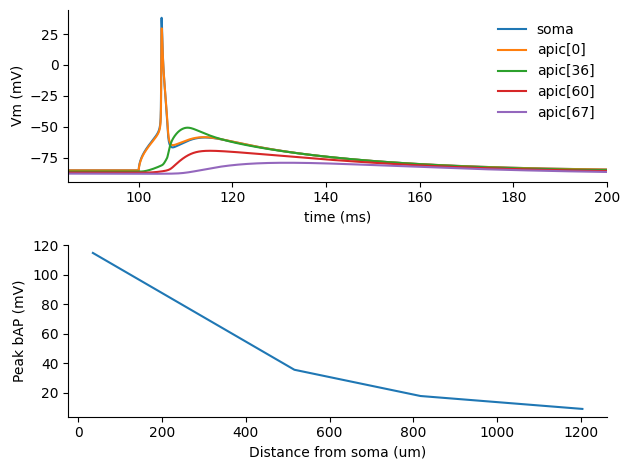

In [16]:
channel_type = 'Ih'
seclist = L5PC.apical

toggleChannelSeclist(channel_type,L5PC,seclist,turn_off=True)

curr_amp = 1.9 # nA - somatic step current amplitude
n_synapses_on = 20 # number of synapses to turn on
distribute_mode = 'even' # how to distribute them within the section
start_time = stim.delay+stim.dur  # when to deliver EPSP

# EPSP + step current
# Turn on synapses and set timing
syn_indices = turnOnSynapses(n_synapses_on,'sequential',netstims,{'number':1,'start':start_time}) # turn on synapses
stim.amp = curr_amp

h.run()

# fig = plot_result(t_vec, v_soma, v_syns[syn_indices[0]], stim_current, i_syns[syn_indices[0]],
#                   show_from = min(start_time,stim.delay) - 20);

toggleChannelSeclist(channel_type,L5PC,seclist,turn_off=False)   # reverts conductances to defaults

apic_rec_peaks = get_peaks(t_vec,v_apics,stim.delay) # peak bAPs in recorded apical dendritic compartments

# Plot here
fig = plt.figure()
ax = fig.add_subplot(211)
ax.plot(t_vec,v_soma,label = 'soma')
for v,ind in zip(v_apics,apic_rec_inds):
    ax.plot(t_vec,v,label='apic[{}]'.format(ind))
ax.set_xlabel('time (ms)')
ax.set_ylabel('Vm (mV)')
ax.legend(frameon=False)
ax.set_xlim(stim.delay - 15,h.tstop)
ax = fig.add_subplot(212)
ax.plot(apic_rec_dists,apic_rec_peaks)
ax.set_xlabel('Distance from soma (um)')
ax.set_ylabel('Peak bAP (mV)')
fig.tight_layout()


<font color='red'>**Q4**: Summarize your findings from these computational experiments. What ion channels supported or inhibited the backpropagation of the action potential into the distal apical dendrite?
</font>

The channels that inhibit the backpropagation are Kv and Kca (potassium channels). When either of these channels are turned off, backpropagation occurs but with both of them on, backpropagation cannot occur.

### Reflections

You've now run a range of computational experiments with a detailed, biophysically-realistic model of a rat neocortical pyramidal cell, exploring how the passive cable properties, active voltage-gated ion channel, and nonlinear synaptic currents interact to mediate dendritic integration. While we only scratched the surface of what's known about dendritic integration in these two exercises, hopefully you have come to appreciate the vast challenge understanding these complex strutures poses. New experiments will unravel more of the inner workings of neuronal function, and these discoveries will require new theories (and models) for us to ultimately make sense of them and translate biological fact to mechanistic understanding.